# 11. *Data Augmentation* y *Transfer Learning*
[**Python Deep Learning** Introducción práctica con Keras y TensorFlow 2. Jordi Torres. Editorial Marcombo ISBN: 9788426728289 ](https://www.marcombo.com/python-deep-learning-9788426728289/)


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0-rc1



## Datos


In [0]:
from google.colab import files
# se debe cargar el fichero “cats_and_dogs_small.zip”
files.upload()

In [0]:
import os
import zipfile

local_zip = '/content/cats_and_dogs_small.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()


In [0]:

base_dir = '/content/cats_and_dogs_small'

train_dir =      os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir =       os.path.join(base_dir, 'test')

# Directorio con las imagenes de training 
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con las imagenes de validation
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directorio con las imagenes de test
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')



In [0]:
print('total training cat images :', len(os.listdir(train_cats_dir ) ))
print('total training dog images :', len(os.listdir(train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

print('total test cat images :', len(os.listdir( test_cats_dir ) ))
print('total test dog images :', len(os.listdir( test_dogs_dir ) ))


total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500
total test cat images : 500
total test dog images : 500


Saving Wiliams-foto1.png to Wiliams-foto1.png


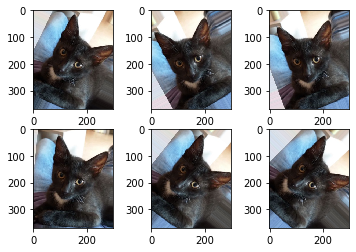

In [0]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from google.colab import files
from tensorflow.keras.preprocessing import image
 
uploaded=files.upload()
for fn in uploaded.keys():
  path='/content/' + fn
  img=image.load_img(path)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  
  # example of "rotation_range"
  datagen = ImageDataGenerator(rotation_range=45)

  it = datagen.flow(samples, batch_size=1)
  for i in range(6):
  	pyplot.subplot(230 + 1 + i)
  	batch = it.next()
  	image = batch[0].astype('uint8')
  	pyplot.imshow(image)
pyplot.show()

### ModelDA: Modelo con *Data Augmentation*

In [0]:
from tensorflow.keras import Model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

modelDA = Sequential()
modelDA.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
modelDA.add(MaxPooling2D(2, 2))
modelDA.add(Conv2D(64, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Conv2D(128, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Conv2D(128, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Flatten())
modelDA.add(Dense(512, activation='relu'))
modelDA.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.optimizers import RMSprop

modelDA.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])



In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


In [0]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyDA = modelDA.fit(
      train_generator,
      steps_per_epoch= steps_per_epoch,
      epochs= 100,
      validation_data= validation_generator,
      validation_steps= validation_steps,
      verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 - 22s - loss: 0.6915 - acc: 0.5285 - val_loss: 0.6991 - val_acc: 0.5010
Epoch 2/100
100/100 - 16s - loss: 0.6760 - acc: 0.5715 - val_loss: 0.6571 - val_acc: 0.5930
Epoch 3/100
100/100 - 16s - loss: 0.6704 - acc: 0.5840 - val_loss: 0.6462 - val_acc: 0.6150
Epoch 4/100
100/100 - 16s - loss: 0.6551 - acc: 0.6065 - val_loss: 0.6457 - val_acc: 0.6080
Epoch 5/100
100/100 - 16s - loss: 0.6427 - acc: 0.6350 - val_loss: 0.6186 - val_acc: 0.6410
Epoch 6/100
100/100 - 16s - loss: 0.6161 - acc: 0.6550 - val_loss: 0.7826 - val_acc: 0.5400
Epoch 7/100
100/100 - 16s - loss: 0.6153 - acc: 0.6600 - val_loss: 0.6238 - val_acc: 0.6460
Epoch 8/100
100/100 - 16s - loss: 0.6060 - acc: 0.6720 - val_loss: 0.6084 - val_acc: 0.6520
Epoch 9/100
100/100 - 16s - loss: 0.6054 - acc: 0.6665 - val_loss: 0.5618 - val_acc: 0.7060
Epoch 10/100
100/100 - 16s - loss: 0.5962 - acc: 0.6740 - val_loss: 0.5512 - va

In [0]:
print (steps_per_epoch)
print (validation_steps)
test_lost, test_acc= modelDA.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

100
50
  ...
    to  
  ['...']
50/50 [==============================] - 3s 54ms/step - loss: 0.5326 - acc: 0.7840
Test Accuracy: 0.784


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

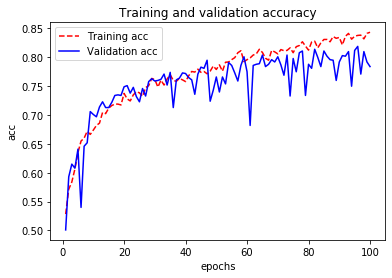

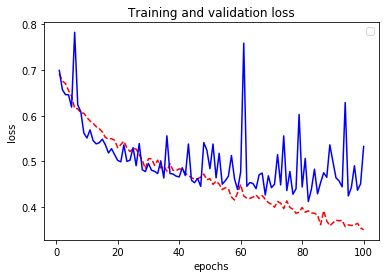

<Figure size 432x288 with 0 Axes>

In [0]:

import matplotlib.pyplot as plt


acc      = historyDA.history[     'acc' ]
val_acc  = historyDA.history[ 'val_acc' ]
loss     = historyDA.history[    'loss' ]
val_loss = historyDA.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()



### ModelFE: Modelo con *Feature Extraction*

In [0]:

from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


pre_trained_model.summary()

for layer in pre_trained_model.layers:
  layer.trainable = False


pre_trained_model.summary()




58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [0]:
from tensorflow.keras import Model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

modelFE = Sequential()
modelFE.add(pre_trained_model)
modelFE.add(Flatten())
modelFE.add(Dense(256, activation='relu'))
modelFE.add(Dense(1, activation='sigmoid'))


In [0]:
modelFE.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from tensorflow.keras.optimizers import RMSprop

modelFE.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFE = modelFE.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 100,
            validation_steps = validation_steps,
            verbose = 2)



  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 - 18s - loss: 0.5224 - acc: 0.7305 - val_loss: 0.3127 - val_acc: 0.8760
Epoch 2/100
100/100 - 17s - loss: 0.4142 - acc: 0.8045 - val_loss: 0.3264 - val_acc: 0.8460
Epoch 3/100
100/100 - 17s - loss: 0.3801 - acc: 0.8285 - val_loss: 0.2664 - val_acc: 0.8930
Epoch 4/100
100/100 - 16s - loss: 0.3718 - acc: 0.8265 - val_loss: 0.3015 - val_acc: 0.8660
Epoch 5/100
100/100 - 17s - loss: 0.3528 - acc: 0.8425 - val_loss: 0.2664 - val_acc: 0.8900
Epoch 6/100
100/100 - 17s - loss: 0.3309 - acc: 0.8490 - val_loss: 0.2611 - val_acc: 0.8930
Epoch 7/100
100/100 - 17s - loss: 0.3309 - acc: 0.8470 - val_loss: 0.2519 - val_acc: 0.9000
Epoch 8/100
100/100 - 17s - loss: 0.3192 - acc: 0.8510 - val_loss: 0.2597 - val_acc: 0.8990
Epoch 9/100
100/100 - 16s - loss: 0.3211 - acc: 0.8610 - val_loss: 0.2968 - val_acc: 0.8820
Epoch 10/100
100/100 - 17s - loss: 0.3182 - acc: 0.8520 - val_loss: 0.2802 - va

In [0]:
test_lost, test_acc= modelFE.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

In [0]:

import matplotlib.pyplot as plt


acc      = historyFE.history[     'acc' ]
val_acc  = historyFE.history[ 'val_acc' ]
loss     = historyFE.history[    'loss' ]
val_loss = historyFE.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
#plt.ylim(0,1)

plt.legend()
plt.figure()




### ModelFT : Modelo con *Fine Tuning*

In [0]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

pre_trained_model.trainable = True

set_trainable = False


for layer in pre_trained_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable: 
    layer.trainable = True
  else:
    layer.trainable = False

pre_trained_model.summary()




In [0]:
modelFT = Sequential()
modelFT.add(pre_trained_model)
modelFT.add(Flatten())
modelFT.add(Dense(256, activation='relu'))
modelFT.add(Dense(1, activation='sigmoid'))


modelFT.summary()

In [0]:
from tensorflow.keras.optimizers import RMSprop

modelFT.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['acc'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))



In [0]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFT = modelFT.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 100,
            validation_steps = validation_steps,
            verbose = 2)


In [0]:


import matplotlib.pyplot as plt

acc      = historyFT.history[     'acc' ]
val_acc  = historyFT.history[ 'val_acc' ]
loss     = historyFT.history[    'loss' ]
val_loss = historyFT.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
plt.ylim(0,1)

plt.legend()
plt.figure()



In [0]:
test_lost, test_acc= modelFT.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

In [0]:

accDA      = historyDA.history[     'acc' ]
val_accDA  = historyDA.history[ 'val_acc' ]

accFE      = historyFE.history[     'acc' ]
val_accFE  = historyFE.history[ 'val_acc' ]

accFT      = historyFT.history[     'acc' ]
val_accFT  = historyFT.history[ 'val_acc' ]

epochs    = range(1,len(accDA)+1,1) 

plt.figure(figsize=(10,18))

plt.plot  ( epochs,     accFT, 'k', label='Fine Tuning - Training acc '  )
plt.plot  ( epochs, val_accFT,  'b', label='Fine Tuning - Validation acc ')

plt.plot  ( epochs,     accFE, 'r--', label='Feature Extraction - Training acc'  )
plt.plot  ( epochs, val_accFE,  'm--', label='Feature Extraction - Validation acc')

plt.plot  ( epochs,     accDA, 'g:', label='Data Augmentation - Training acc'  )
plt.plot  ( epochs, val_accDA,  'c:', label='Data Augmentation - Validation acc')

plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.ylim(0.5,1)
plt.xlabel('epochs')


plt.legend()
plt.figure()





In [0]:
import numpy as np

from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded=files.upload()
file=list(uploaded.keys())[0]

path='/content/' + file
img=image.load_img(path, target_size=(150, 150))

x=image.img_to_array(img)
image=np.expand_dims(x, axis=0)  

classes = model.predict(image)
print(classes)

plt.imshow(img)
plt.show()

if classes>0: print( fn + " IS A DOG")
else: print( fn + " IS A CAT")
